# Sparkify 项目
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, count
from pyspark.sql.types import IntegerType

In [2]:
# create a Spark session
ss = SparkSession.builder \
    .master('local') \
    .appName('Sparkify') \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
df = ss.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter(df["userId"] != "")

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [5]:
df.select('page').distinct().show(100)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [6]:
churn_df = df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
churn_user_ids = [cdf["userId"] for cdf in churn_df.collect()]

In [7]:
df = df.withColumn('churn', df.userId.isin(churn_user_ids))

In [8]:
df.select('churn').dropDuplicates().show()

+-----+
|churn|
+-----+
| true|
|false|
+-----+



### 1. 流失率与性别的关系？

In [9]:
df.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



In [10]:
pdf = df.dropDuplicates(['userId']).groupby(['gender','churn']).count().toPandas()

In [11]:
churn_male_count = pdf.query("gender == 'M' & churn == True")['count'].sum()
total_male_count = pdf.query("gender == 'M'")['count'].sum()

churn_female_count = pdf.query("gender == 'F' & churn == True")['count'].sum()
total_female_count = pdf.query("gender == 'F'")['count'].sum()

churn_rate_of_male = churn_male_count/total_male_count
churn_rate_of_female = churn_female_count/total_female_count

print('The churn rate of male is {:.2f}'.format(churn_rate_of_male))
print('The churn rate of female is {:.2f}'.format(churn_rate_of_female))

The churn rate of male is 0.26
The churn rate of female is 0.19


### 2.流失率与播放的歌曲数量的关系？

In [12]:
df_songs = df.groupby(['churn', 'userId']).agg(count(df.song).alias('songsPlayed')).toPandas()

In [13]:
df_songs.hist('songsPlayed', by='churn');

### 3.流失率与用户点赞/点踩的关系？

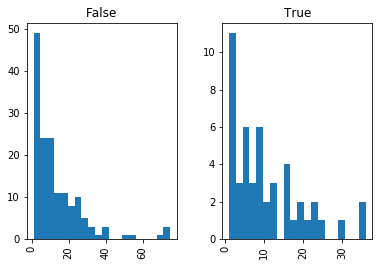

In [14]:
df_thumbs_down = df.where(df.page == 'Thumbs Down').groupby(['churn', 'userId']).agg(count(df.page).alias('thumbsDowns')).toPandas()
df_thumbs_down.hist('thumbsDowns', by='churn', bins=20);

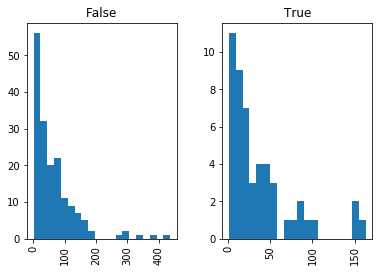

In [15]:
df_thumbs_up = df.where(df.page == 'Thumbs Up').groupby(['churn', 'userId']).agg(count(df.page).alias('thumbsUps')).toPandas()
df_thumbs_up.hist('thumbsUps', by='churn', bins=20);

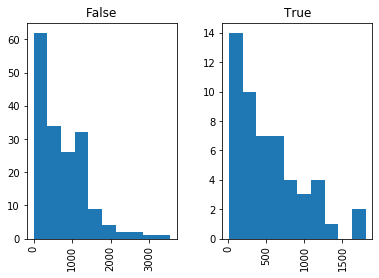

In [16]:
df_artists = df.dropDuplicates(['churn', 'userId', 'artist']).groupby(['churn', 'userId']).agg(count(df.artist).alias('artistsPlayed')).toPandas()
df_artists.hist('artistsPlayed', by='churn');

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

#### **特征1：性别**

In [17]:
df_gender = df.select(['userId', 'gender']).dropDuplicates(['userId']).sort('userId')
df_gender = df_gender.replace(['M', 'F'], ['1', '0'], 'gender')

#### **特征2：播放歌曲数量**

In [18]:
df_songs = df.groupby('userId').agg(count(df.song).alias('songsPlayed')).sort('userId')

#### **特征3：播放不同演唱者的数量**

In [19]:
df_artists = df.dropDuplicates(['userId', 'artist']).groupby('userId').agg(count(df.artist).alias('artistsPlayed')).sort('userId')

#### **特征4：点赞次数**

In [20]:
df_thumb_ups = df.filter(df.page == 'Thumbs Up').groupby('userId').agg(count(df.page).alias('thumbsUps')).sort('userId')

#### **特征5：点踩次数**

In [21]:
df_thumb_downs = df.filter(df.page == 'Thumbs Down').groupby('userId').agg(count(df.page).alias('thumbsDowns')).sort('userId')

### 合并特征

In [22]:
df_features = df.select(['userId', 'churn']).dropDuplicates(['userId']).sort('userId')
for feature in [df_gender, df_songs, df_artists, df_thumb_ups, df_thumb_downs]:
    df_features = df_features.join(feature, 'userId')

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, recall_score, precision_score

In [24]:
df_features.show(5)

+------+-----+------+-----------+-------------+---------+-----------+
|userId|churn|gender|songsPlayed|artistsPlayed|thumbsUps|thumbsDowns|
+------+-----+------+-----------+-------------+---------+-----------+
|    10|false|     1|        673|          565|       37|          4|
|   100|false|     1|       2682|         1705|      148|         27|
|100001| true|     0|        133|          125|        8|          2|
|100004|false|     0|        942|          733|       35|         11|
|100005| true|     1|        154|          149|        7|          3|
+------+-----+------+-----------+-------------+---------+-----------+
only showing top 5 rows



In [25]:
df_features.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('songsPlayed', 'bigint'),
 ('artistsPlayed', 'bigint'),
 ('thumbsUps', 'bigint'),
 ('thumbsDowns', 'bigint')]

In [26]:
# convert data type of columns into float
for col in df_features.columns[1:]:
    df_features = df_features.withColumn(col, df_features[col].cast('float'))

df_features.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('gender', 'float'),
 ('songsPlayed', 'float'),
 ('artistsPlayed', 'float'),
 ('thumbsUps', 'float'),
 ('thumbsDowns', 'float')]

In [27]:
df_train, df_test = df_features.randomSplit([0.8, 0.2], seed = 42)

### 逻辑回归

In [28]:
assembler = VectorAssembler(inputCols = df_features.columns[2:], outputCol = 'featuresVect')
scaler = StandardScaler(inputCol = 'featuresVect', outputCol = 'features', withStd = True)
indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')

In [29]:
lr = LogisticRegression(maxIter = 10, regParam = 0.0, elasticNetParam = 0)

In [30]:
# 建立管道
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

# 参数
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.01]) \
    .build()

# 交叉验证
crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 3)

In [31]:
cvModel_lr = crossval_lr.fit(df_train)

In [32]:
cvModel_lr.avgMetrics

[0.6273889375930192, 0.6117656342146137, 0.6324873161607856]

In [33]:
# test performance
results = cvModel_lr.transform(df_test)
BinaryClassificationEvaluator().evaluate(results)

0.7562724014336917

#### 结果

看起来正则化强度为 0.0 的时候效果最好，训练集达到0.629，而测试集上高达0.767

### 随机森林

In [34]:
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [35]:
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, rf])

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 30]) \
    .build()

crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid_rf,
                             evaluator = BinaryClassificationEvaluator(),
                             numFolds = 3)

In [36]:
cvModel_rf = crossval_rf.fit(df_train)

In [37]:
cvModel_rf.avgMetrics

[0.5721148466046425, 0.5439719011147582]

In [38]:
# test performance
results = cvModel_rf.transform(df_test)
BinaryClassificationEvaluator().evaluate(results)

0.5806451612903226

#### 结果

最终在训练集上F1分数是0.58，在测试集上同样是0.58

#### 结果讨论

实验了两个模型：LogisticRegression, RandomForestClassifier，其中效果最好的是逻辑回归模型（F1_score：0.767），可以采用该模型进行预测流失用户。

#### 反思

预测流失用户，本质上是针对用户的二分类问题，因此适合采用监督学习的机器学习方法。项目主要流程包括：数据清洗，探索性分析，特征工程，监督学习建模，建模过程中采用F1分数对模型进行评估和改进。

在这个问题上，由于特征较少，所以随机森林算法没有优势，逻辑回归算法表现更好。项目中，可以提取更多的特征，以及更多的参数来对模型进行改进。

#### 改进

一开始计划之后修改原始数据来进行建模，思考后改成了用包含特征属性的新数据集来进行建模；最好不要破解原始数据，这样可以尝试多次提取不同的特征来进行建模。